# Utils

In [23]:
import cryo
import polars as pl

In [24]:
# Utils functions

def convert_to_type(data, type, data_offset = 0):
    ''' Convert raw data to a specific type
    data: the raw data (bytes)
    type: the type of the data
    data_offset: the offset of the data in the raw data'''
    
    if type == 'string':
        offset = int(data[data_offset: data_offset+32].hex(), 16)
        length = int(data[offset:offset + 32].hex(), 16)
        return data[offset + 32: offset + 32 + length].decode('utf-8')
    elif len(type) > 4 and type[:4] == 'uint':
        if (data[data_offset+22: data_offset+32].hex() == ''):
            return 0
        return float(int(data[data_offset+22: data_offset+32].hex(), 16))
    elif len(type) > 3 and type[:3] == 'int':
        if (data[data_offset+22: data_offset+32].hex() == ''):
            return 0
        return float(int(data[data_offset+22: data_offset+32].hex(), 16))
    elif type == 'address':
        return '0x' + data[12+data_offset:32+data_offset].hex()
    elif type == 'bool':
        return int(data[data_offset: 32 + data_offset].hex(), 16) > 0
    elif len(type) > 5 and type[:5] == 'bytes':
        bytes_left = 32 - int(type[5:])
        return '0x' + data[data_offset+bytes_left: data_offset+32].hex()
    else:
        raise ValueError("Type not handled yet")

def type_name(type):
    if type == 'string':
        return type(str)
    elif len(type) > 4 and type[:4] == 'uint':
        return type(int)
    elif len(type) > 3 and type[:3] == 'int':
        return type(int)
    elif type == 'address':
        return type(str)
    elif type == 'bool':
        return type(bool)
    elif len(type) > 5 and type[:5] == 'bytes':
        return type(str)
    else:
        raise ValueError("Type not handled yet")
    
def parse_raw_events(raw_events: pl.DataFrame, signature: str) -> pl.DataFrame:
    '''
    Parse raw events from a DataFrame, this dataframe should contain the following columns:
    - topic0 to topic3: the topics of the event
    - data: the data of the event
    The signature is used to determine the type of the event, it should look like this:
    "EventName(uint256 indexed arg1, uint256 indexed arg2, T arg3, ...)"

    The function works with basic types (string, uint, address, bool, bytes) but not yet (TODO) with arrays or structs.
    '''
    
    # Parse the signature
    first_parenthesis = signature.find('(')
    last_parenthesis = signature.rfind(')')

    print(f'Parsing Event name: {signature[:first_parenthesis]}')

    types_str = signature[first_parenthesis + 1:last_parenthesis]
    types = types_str.split(',')
    indexed_types, data_types = [], []

    for t in types:
        parts = t.strip().split(' ')
        if 'indexed' in parts:
            indexed_types.append((parts[0], parts[-1]))
        else:
            data_types.append((parts[0], parts[-1]))

    dfs = []
    for index, (type, name) in enumerate(data_types):
        data_events_cur_df = raw_events.select([
            pl.col("data").map_elements(lambda x: convert_to_type(x, type, 32*index), return_dtype=type_name(type)).alias(name)
        ] + [pl.col("block_number"), pl.col("transaction_index", "log_index")])
        dfs.append(data_events_cur_df)

    indexed_events_df = raw_events.select([
        pl.col(f"topic{1+index}").map_elements(lambda x: convert_to_type(x, type), return_dtype=type_name(type)).alias(name)
        for index, (type, name) in enumerate(indexed_types)
    ] + [pl.col("block_number"), pl.col("transaction_index", "log_index")])

    print(f'Indexed types: {indexed_types}')
    print(f'Data types: {data_types}')
    

    res_df = indexed_events_df
    for df in dfs:
        res_df = res_df.join(df, on=["block_number", "transaction_index", "log_index"], how="inner")

    return res_df

In [25]:
# Block timestamps database

blocks: pl.DataFrame = (
    pl.scan_parquet("blocks__block_time/*.parquet")
    .collect()
)
blocks = blocks.with_columns(
    pl.col("timestamp").alias("temp")
)
blocks = blocks.with_columns(
    # Expects timestamps in micro seconds
    (pl.col("temp").cast(pl.Int64) * 1000000).cast(pl.Datetime)
)
blocks.columns = ['block_number', 'timestamp', 'time']

# Liquidation events

In [26]:
LIQUIDATION_EVENT_SIG = "event LiquidationCall(address indexed collateralAsset, address indexed debtAsset, address indexed user, uint256 debtToCover, uint256 liquidatedCollateralAmount, address liquidator, bool receiveAToken);"
LIQUIDATION_EVENT_HASH = "0xe413a321e8681d831f4dbccbca790d2952b56f977908e45be37335533e005286"
AAVE_V3_POOL = "0x87870Bca3F3fD6335C3F4ce8392D69350B4fA4E2"
AAVE_V2_POOL = "0x7d2768dE32b0b80b7a3454c06BdAc94A69DDc7A9"

# Collect the raw events with specific cryo params
paramsV3 = {
    "datatype": "events",
    "blocks": ["16M:19M"], # AaveV3 deployed at 16291127
    "inner_request_size": 100_000,
    "contract": [AAVE_V3_POOL],
    "topic0": [LIQUIDATION_EVENT_HASH]
}
paramsV2 = {
    "datatype": "events",
    "blocks": ["13M:19M"], # AaveV2 deployed at 11362579
    "inner_request_size": 100_000,
    "contract": [AAVE_V2_POOL],
    "topic0": [LIQUIDATION_EVENT_HASH]
}

# Collect the raw events with cryo
liquidations_raw = pl.concat([cryo.collect(**paramsV2), cryo.collect(**paramsV3)])

# Parse the raw events to a DataFrame with a specific event signature
liquidations = parse_raw_events(liquidations_raw, LIQUIDATION_EVENT_SIG)

# Add timestamps
liquidations = liquidations.join(blocks, on='block_number', how="left")

Parsing Event name: event LiquidationCall
Indexed types: [('address', 'collateralAsset'), ('address', 'debtAsset'), ('address', 'user')]
Data types: [('uint256', 'debtToCover'), ('uint256', 'liquidatedCollateralAmount'), ('address', 'liquidator'), ('bool', 'receiveAToken')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

In [27]:
# Prices

import requests

url = "https://raw.githubusercontent.com/morpho-org/morpho-risk-api/main/src/schemas/asset-price-mappings/oracle-prices.json?token=GHSAT0AAAAAACOKU6H3FFUYYGOXAHJHZJSSZRCURHQ"
response = requests.get(url)
data = response.json()
aggregators = pl.DataFrame(data)

ANSWER_UPDATED_SIG = "AnswerUpdated(int256 current,uint256 roundId,uint256 timestamp)"
ANSWER_UPDATED_HASH = "0x0559884fd3a460db3073b7fc896cc77986f16e378210ded43186175bf646fc5f"

def historical_prices(address):
    # USD
    print(address)
    if aggregators.filter(pl.col('assetAddress').cast(pl.Utf8).str.to_lowercase() == address).is_empty():
        print("skipped")
        return
    params = {
        "datatype": "events",
        "blocks": ["13M:19M"], # AaveV2 deployed at 11362579
        "inner_request_size": 100_000,
        "contract": [aggregators.filter(pl.col('assetAddress').cast(pl.Utf8).str.to_lowercase() == address).row(0)[1]],
        "topic0": [ANSWER_UPDATED_HASH]
    }

    prices_raw = cryo.collect(**params)
    prices = parse_raw_events(prices_raw, ANSWER_UPDATED_SIG)
    prices = prices.join(blocks, on='block_number', how="left")

    return prices

prices = pl.concat([historical_prices(address) for address in liquidations['collateralAsset'].unique()])
prices.head(5)

0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0xdac17f958d2ee523a2206206994597c13d831ec7
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0x408e41876cccdc0f92210600ef50372656052a38
0xe41d2489571d322189246dafa5ebde1f4699f498
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0xd533a949740bb3306d119cc777fa900ba034cd52
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0x0f5d2fb29fb7d3cfee444a200298f468908cc942
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0xc011a73ee8576fb46f5e1c5751ca3b9fe0af2a6f
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0x4e3fbd56cd56c3e72c1403e103b45db9da5b9d2b
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0x1f9840a85d5af5bf1d1762f925bdaddc4201f984
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0x0000000000085d4780b73119b644ae5ecd22b376
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0x0d8775f648430679a709e98d2b0cb6250d2887ef
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0xc18360217d8f7ab5e7c516566761ea12ce7f9d72
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0xae7ab96520de3a18e5e111b5eaab095312d7fe84
Parsing Event name: AnswerUpdated
Indexed types: []
Data types: [('int256', 'current'), ('uint256', 'roundId'), ('uint256', 'timestamp')]


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0
Parsing Event name: AnswerUpdated


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


ComputeError: ComputeError: The output type of the 'apply' function cannot be determined.
The function was never called because 'skip_nulls=True' and all values are null.
Consider setting 'skip_nulls=False' or setting the 'return_dtype'.

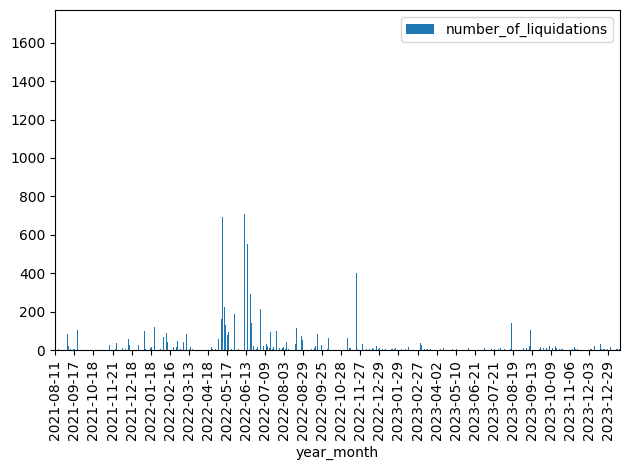

In [41]:
# Monthly liquidations

import matplotlib.pyplot as plt

# Extract year and month and count the number of liquidations
monthly_liquidations = liquidations.with_columns(pl.col("time").dt.strftime("%Y-%m-%d").alias("year_month")).group_by("year_month").agg(pl.len().alias("number_of_liquidations"))
monthly_liquidations = monthly_liquidations.sort("year_month")

# Plotting
monthly_liquidations_df = monthly_liquidations.to_pandas()
monthly_liquidations_df.plot(kind='bar', x='year_month', y='number_of_liquidations')
# plt.xticks(rotation=45)
# plt.figure(figsize=(15, 10))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))
plt.tight_layout()
plt.show()